# Figure 1: W189b phase coverage and observational parameters

## Fig. 1a: Phase coverage

In [39]:
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

APJ_SINGLE_COL = 3.5
APJ_DOUBLE_COL = 7.
TEXTSIZE=12

WR_RED = '#80273F'
WR_GREEN = '#008000'

target = 'WASP-189'
semimajor = 0.05053
Rstar = (2.33 * u.Rsun).to(u.au).value
Rp = (1.619 * u.Rjup).to(u.au).value
Tdur = 4.3336 * u.h
P = 2.7240308 * u.d
phase_eclipse_start = 0.5 - (Tdur/P).to(u.dimensionless_unscaled).value * 0.5
phase_eclipse_end = 0.5 + (Tdur/P).to(u.dimensionless_unscaled).value * 0.5

def polar_to_cartesian(r, theta, incl=90.):
    x = r * np.cos(theta-np.pi/2.)
    y = r * np.sin(theta-np.pi/2.) #* np.cos(incl)
    return x, y

def plot_orbit(r):
    x, y = polar_to_cartesian(r=semimajor, theta=np.linspace(0,np.pi*2,100))
    plt.plot(x, y, ls=':', color='k', lw=1)
    
def plot_planet(r):
    labels = [0,0.25,0.5,0.75]
    ha_list = ['center', 'left', 'center', 'right']
    va_list = ['top', 'center', 'bottom', 'center']
    pts = [(x,y) for x,y in zip(*polar_to_cartesian(r=r*1.1, theta=np.linspace(0,0.75,4)*2*np.pi))]
    for n, (pt, ha, va) in enumerate(zip(pts, ha_list, va_list)):
        plt.annotate(r"$\phi$="f"{labels[n]}", xy=pt, va=va, ha=ha, size=TEXTSIZE)
    
    x, y = polar_to_cartesian(r=r, theta=np.linspace(0,0.75,4)*2*np.pi)
    for xi, yi in zip(x,y):
        ci = plt.Circle((xi, yi), Rp, color='k')
        ax.add_artist(ci)
        

        
def plot_star(Rstar):
    plt.annotate('star', xy=(0., 0.), va='center', ha='center', color='k', size=TEXTSIZE)
    c = plt.Circle((0.,0.), Rstar, color='gold', alpha=1)
    ax.add_artist(c)

phases_list = [
    np.load(f'../data/phase_coverage/ph_arr_night_{night}.npy') for night in (1,2)
]

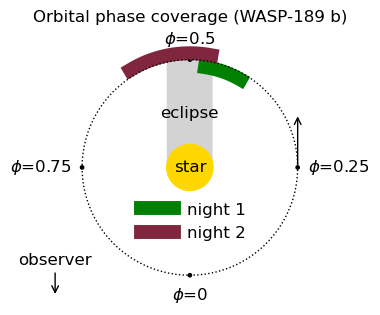

In [40]:
fig = plt.figure(figsize=(APJ_SINGLE_COL, APJ_SINGLE_COL))
ax = fig.add_subplot(111)

offset=6e-3
colors = [WR_GREEN, WR_RED]
labels = ['night 1', 'night 2']
for n, phases in enumerate(phases_list):
    x, y = polar_to_cartesian(r=semimajor+offset*(n-0.5),
                              theta=phases*2*np.pi)
    plt.plot(x, y, lw=10, color=colors[n], label=labels[n], alpha=1)    
ax.legend(bbox_to_anchor=(0.25,0.3), fontsize=TEXTSIZE, ncol=1, edgecolor='w',  borderpad=0.6, facecolor='w')

# Plot orbit
plot_orbit(r=semimajor)
plot_planet(r=semimajor)
plot_star(Rstar=Rstar)

# Plot eclipse
x_eclipse_start, y_eclipse_start = polar_to_cartesian(r=semimajor, theta=phase_eclipse_start*2*np.pi)
x_eclipse_end, y_eclipse_end = polar_to_cartesian(r=semimajor, theta=phase_eclipse_end*2*np.pi)

ax.fill_between(x=x[np.abs(x) < Rstar], y1=np.zeros(len(x[np.abs(x) < Rstar])), y2=y[np.abs(x) < Rstar], color='lightgray', zorder=-100)
plt.annotate('eclipse', xy=(0., semimajor/2.), va='center', ha='center', color='k', size=TEXTSIZE, alpha=1)

# Plot ranges
plt.xlim(-1.25*semimajor,1.25*semimajor)
plt.ylim(-1.25*semimajor,1.25*semimajor)
ax.set_aspect(aspect=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax.annotate('observer', xytext=(-1.25*semimajor, -0.9*semimajor), xy=(-1.25*semimajor, -1.2*semimajor),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=12, ha='center')

ax.annotate('', xytext=(semimajor, 0.), xy=(semimajor, 0.5*semimajor),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=12, ha='center')


plt.title('Orbital phase coverage (WASP-189 b)', fontsize=TEXTSIZE, y=1.01)
fname = 'Fig1a_W189b_phase_coverage'
plt.savefig('../figures/'+fname+'.png', dpi=200, bbox_inches='tight')
plt.savefig('../figures/'+fname+'.pdf', bbox_inches='tight')
plt.show()

## Fig.1b: S/N versus airmass

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from astropy.io import fits

Load data corresponding with the S/N and phase coverage.

In [42]:
wls_cube_n1 = np.load('../data/snr/wls_cube_night_1.npy')
wls_cube_n2 = np.load('../data/snr/wls_cube_night_2.npy')

snr_cube_n1 = np.load('../data/snr/snr_cube_night_1.npy')
snr_cube_n2 = np.load('../data/snr/snr_cube_night_2.npy')

ph_arr_n1 = np.load('../data/phase_coverage/ph_arr_night_1.npy')
ph_arr_n2 = np.load('../data/phase_coverage/ph_arr_night_2.npy')

am_arr_n1 = np.load('../data/phase_coverage/am_arr_night_1.npy')
am_arr_n2 = np.load('../data/phase_coverage/am_arr_night_2.npy')

Load humidity data and nodding position of each frame.

In [43]:
frame = 1
hum = []
nodpos = []
temp = []
for frame in range(200):
    try:
        hdul = fits.open(f'/Users/lsluijs/Projects/WINERED/pre_processing/WASP-189/2023A/2023_06_09/WARP_out/WASP-189_NO{frame}/onedspec/VAC_norm/fsr1.30/WASP-189_NO{frame}_m138_fsr1.30_VAC_norm.fits')
        hum.append(hdul[0].header['OUT-HUM'])
        nodpos.append(hdul[0].header['NODPOS'])
    except:
        pass

nodpos_n1 = []
nodpos_n2 = []

for frame in range(400):
    try:
        hdul = fits.open(f'/Users/lsluijs/Projects/WINERED/pre_processing/WASP-189/2023A/2023_06_09/WARP_out/WASP-189_NO{frame}/onedspec/VAC_norm/fsr1.30/WASP-189_NO{frame}_m138_fsr1.30_VAC_norm.fits')
        value = hdul[0].header['NODPOS']
        if 'A' in value:
            nodpos_n1.append('A')
        if 'B' in value:
            nodpos_n1.append('B')
    except:
        pass

for frame in range(400):
    try:
        hdul = fits.open(f'/Users/lsluijs/Projects/WINERED/pre_processing/WASP-189/2024A/2024_04_19/WARP_out/WASP-189_NO{frame}/onedspec/VAC_norm/fsr1.30/WASP-189_NO{frame}_m138_fsr1.30_VAC_norm.fits')
        nodpos_n2.append(hdul[0].header['NODPOS'])
    except:
        pass


nodpos_n1 = np.array(nodpos_n1)
nodpos_n2 = np.array(nodpos_n2)

nodpos_mask_n1 = []
for np1, np2 in zip(nodpos_n1[:-1], nodpos_n1[1:]):
    if np1 == np2:
        nodpos_mask_n1.append(True)
    else:
        nodpos_mask_n1.append(False)

nodpos_mask_n2 = []
for np1, np2 in zip(nodpos_n2[:-1], nodpos_n2[1:]):
    if np1 == np2:
        nodpos_mask_n2.append(True)
    else:
        nodpos_mask_n2.append(False)

nodpos_mask_n1 = np.array(nodpos_mask_n1)
nodpos_mask_n2 = np.array(nodpos_mask_n2)

In [44]:
APJ_SINGLE_COL = 3.5
APJ_DOUBLE_COL = 7.
TEXTSIZE=12
TICKSIZE=10

WR_RED = '#80273F'
WR_GREEN = '#008000'

/var/folders/fr/d4gym27d0y1dw670nr2vpn5c0000gr/T/ipykernel_6221/1101157504.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_snr = plt.subplot(gs[0,0])


phase coverage 0.4165768604657387 0.4762042956501773
# frames 125
FWHM night 1 4.629846387209716
phase coverage 0.46973529086858434 0.5876877827131466
# frames 268
FWHM night 2 5.103975476449447


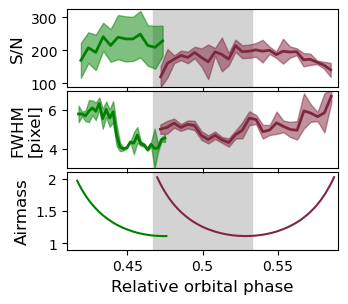

In [45]:
# Frame bin size used for S/N and FWHM
frame_binning = 10.

# Create figure
fig, ax_snr = plt.subplots(figsize=(APJ_SINGLE_COL, APJ_SINGLE_COL*1.5*(1./1.68)))
gs = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, hspace=0.05)
ax_snr = plt.subplot(gs[0,0])
ax_am = plt.subplot(gs[2,0])
ax_fwhm = plt.subplot(gs[1,0])

# SNR plot
for i, (snr_cube, plot_label, plot_color, ph_arr) in enumerate(zip(
    (snr_cube_n1, snr_cube_n2),
    ('S/N night 1', 'S/N night 2'),
    (WR_GREEN, WR_RED),
    (ph_arr_n1, ph_arr_n2))):
    nbins_plot = int(snr_cube.shape[0]/frame_binning)
    frames = np.arange(0.5, snr_cube.shape[0], 1)
    
    ph_arr_t = ph_arr[:-1] + np.diff(ph_arr)/2.

    snr_time = np.median(snr_cube, axis=(1,2))
    snr_time_b, bin_edges, _ = binned_statistic(x=ph_arr_t, values=snr_time, statistic=np.median, bins=nbins_plot)
    snr_time_std_b, _, _ = binned_statistic(x=ph_arr_t, values=snr_time, statistic=np.std, bins=nbins_plot)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    ax_snr.fill_between(x=bin_centers, y1=snr_time_b-snr_time_std_b, y2=snr_time_b+snr_time_std_b, color=plot_color, alpha=0.5)
    ax_snr.plot(bin_centers, snr_time_b, color=plot_color, lw=2)
    
ax_snr.set_ylabel('S/N', size=TEXTSIZE)
ax_snr.set_ylim(90,325)

# Plot FWHM
fwhm_arr_n1 = np.load('../data/phase_coverage/fwhm_n1.npy')
fwhm_arr_n2 = np.load('../data/phase_coverage/fwhm_n2.npy')
for i, (fwhm_arr, ph_arr, plot_color, plot_label) in enumerate(zip(
    (fwhm_arr_n1, fwhm_arr_n2),
    (ph_arr_n1, ph_arr_n2),
    (WR_GREEN, WR_RED),
    ('FWHM night 1', 'FWHM night 2'))):
    
    fwhm_arr_b, bin_edges, _ = binned_statistic(x=ph_arr, values=fwhm_arr, statistic=np.median, bins=nbins_plot)
    fwhm_arr_std_b, _, _ = binned_statistic(x=ph_arr, values=fwhm_arr, statistic=np.std, bins=nbins_plot)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    ax_fwhm.fill_between(x=bin_centers, y1=fwhm_arr_b-fwhm_arr_std_b, y2=fwhm_arr_b+fwhm_arr_std_b, color=plot_color, alpha=0.5)
    ax_fwhm.plot(bin_centers, fwhm_arr_b, color=plot_color, lw=2)
    
    print('phase coverage',  np.min(ph_arr), np.max(ph_arr))
    print('# frames', len(ph_arr))
    print(plot_label, np.median(fwhm_arr_b))

ax_fwhm.set_ylim(3,7.)
ax_fwhm.set_ylabel('FWHM\n[pixel]', size=TEXTSIZE)

# Airmass plot
for i, (am_arr, ph_arr, plot_color, plot_label) in enumerate(zip(
    (am_arr_n1, am_arr_n2),
    (ph_arr_n1, ph_arr_n2),
    (WR_GREEN, WR_RED),
    ('airmass night 1', 'airmass night 2'))):
    
    ph_arr_t = ph_arr[:-1] + np.diff(ph_arr)/2.
    airmass = am_arr[:-1] + np.diff(am_arr)/2.
    ax_am.plot(ph_arr_t, airmass, color=plot_color, ls='-', label=plot_label)
    
ax_am.set_xticks([0.4,0.45,0.5,0.55,0.6])
ax_am.set_xticklabels(['','','','',''])
ax_am.set_ylim(0.9,2.1)
ax_am.set_ylabel('Airmass', size=TEXTSIZE)
ax_am.set_yticks([1,1.5,2])
ax_am.set_yticklabels([1,1.5,2])

eclipse_window = (0.46685671346545227, 0.5331432865345478)
for ax in (ax_am, ax_snr, ax_fwhm):
    ax.set_xticks([0.45,0.5,0.55])
    ax.set_xticklabels(['','',''])
    ax.set_xlim(0.41,0.59)
    ax.fill_between(x=[eclipse_window[0], eclipse_window[1]],y1=-1, y2=350, color='lightgray', zorder=-100)
    
ax_am.set_xticklabels([0.45,0.5,0.55])
ax_am.set_xlabel('Relative orbital phase', size=TEXTSIZE)

plt.savefig(f'../figures/Fig1b_obs_params.png', dpi=150, bbox_inches='tight')
plt.savefig(f'../figures/Fig1b_obs_params.pdf', bbox_inches='tight')
plt.show()